In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.ndimage import histogram
import os
os.makedirs('./plot', exist_ok=True)

254


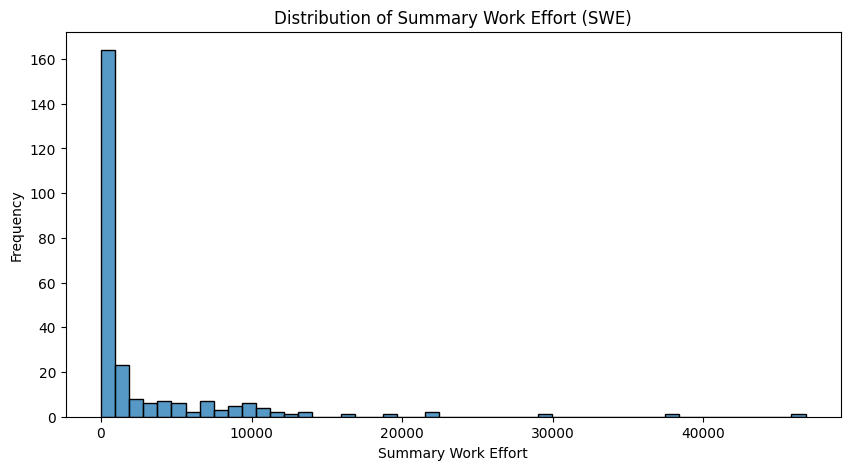

In [2]:
# Importing ISBG as dataframe
ISBG = pd.read_excel("./data/ISBSG-whole.xlsx",header=3)
# ISBG.set_index("Project ID", inplace=True)

cols_needed = ['Max Team Size','COSMIC Read','COSMIC Write','COSMIC Entry','COSMIC Exit','Functional Size','Project Elapsed Time','Development Platform','Primary Programming Language','Summary Work Effort']
ISBG_interest = ISBG[cols_needed]
ISBG_interest.head()

df_clean = ISBG_interest.dropna(subset=["COSMIC Read", "COSMIC Write", "COSMIC Exit", "COSMIC Entry"])
print(len(df_clean))
plt.figure(figsize=(10,5))
sns.histplot(df_clean['Summary Work Effort'], kde=False, bins=50)  # Set bins and kde to False

plt.title('Distribution of Summary Work Effort (SWE)')
plt.xlabel('Summary Work Effort')
plt.ylabel('Frequency')
plt.savefig('./plot/dfCleanhistogram.svg')
plt.show()

df_clean = df_clean.dropna(subset=['Summary Work Effort'])


In [3]:
# Log-transform target variable before split
y_clean = np.log(df_clean["Summary Work Effort"] + 1)
X_clean = df_clean.drop(columns=["Summary Work Effort"])

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_clean, test_size=0.2, random_state=42
)

# Separate numeric and categorical columns
num_cols = X_train.select_dtypes(include='number').columns
cat_cols = X_train.select_dtypes(exclude='number').columns

# Impute numeric values using KNN (fit only on training data)
from sklearn.impute import KNNImputer
imputer_num = KNNImputer(n_neighbors=5)
X_num_train = pd.DataFrame(imputer_num.fit_transform(X_train[num_cols]), columns=num_cols, index=X_train.index)
X_num_test = pd.DataFrame(imputer_num.transform(X_test[num_cols]), columns=num_cols, index=X_test.index)

# Impute categorical values using most frequent strategy (fit only on training data)
from sklearn.impute import SimpleImputer
imputer_cat = SimpleImputer(strategy="most_frequent")
X_cat_train = pd.DataFrame(imputer_cat.fit_transform(X_train[cat_cols]), columns=cat_cols, index=X_train.index)
X_cat_test = pd.DataFrame(imputer_cat.transform(X_test[cat_cols]), columns=cat_cols, index=X_test.index)

# Combine imputed columns
X_train_imputed = pd.concat([X_num_train, X_cat_train], axis=1)
X_test_imputed = pd.concat([X_num_test, X_cat_test], axis=1)

# Scale numeric columns (fit on training data only)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_num_train_scaled = pd.DataFrame(scaler.fit_transform(X_num_train), columns=num_cols, index=X_train.index)
X_num_test_scaled = pd.DataFrame(scaler.transform(X_num_test), columns=num_cols, index=X_test.index)

# Combine scaled numeric and imputed categorical
X_train_final = pd.concat([X_num_train_scaled, X_cat_train], axis=1)
X_test_final = pd.concat([X_num_test_scaled, X_cat_test], axis=1)

# --- Feature separation for experiments (AFTER preprocessing) ---

# Functional features (numerical, already scaled)
functional_features = ["COSMIC Read", "COSMIC Write", "COSMIC Entry", "COSMIC Exit"]
X_func_train = X_train_final[functional_features]
X_func_test = X_test_final[functional_features]

# Technical features
tech_features = ["Development Platform", "Primary Programming Language", 
                 "Project Elapsed Time", "Max Team Size"]
tech_cat_cols = ["Development Platform", "Primary Programming Language"]

X_tech_train = X_train_final[tech_features]
X_tech_test = X_test_final[tech_features]

# One-hot encode technical categorical columns
X_tech_train = pd.get_dummies(X_tech_train, columns=tech_cat_cols, drop_first=True)
X_tech_test = pd.get_dummies(X_tech_test, columns=tech_cat_cols, drop_first=True)


In [4]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error
from sklearn.tree import DecisionTreeRegressor
import numpy as np
import shap 

# Define model
dt = DecisionTreeRegressor(random_state=42)
"""""
# Define scoring metrics (on log scale)
scoring = {
    'r2': 'r2',
    'mae': make_scorer(mean_absolute_error),
    'mse': make_scorer(mean_squared_error),
}

# Run 5-fold cross-validation
cv_results = cross_validate(
    dt,
    X_train,
    y_train,  # log-transformed SWE
    cv=10,
    scoring=scoring,
    return_train_score=False
)

# Show average scores
for metric in scoring:
    scores = cv_results[f'test_{metric}']
    print(f"{metric.upper()} (mean ± std): {scores.mean():.4f} ± {scores.std():.4f}")

"""

def evaluate_model(X, y, model=None, label=""):
    if model is None:
        model = DecisionTreeRegressor(random_state=42)
    scoring = {
        'r2': 'r2',
        'mae': make_scorer(mean_absolute_error),
        'mse': make_scorer(mean_squared_error),
    }

    results = cross_validate(model, X, y, cv=10, scoring=scoring, return_train_score=False)

    print(f"\n--- {label} ---")
    for metric in scoring:
        scores = results[f'test_{metric}']
        print(f"{metric.upper()} (mean ± std): {scores.mean():.4f} ± {scores.std():.4f}")


# Functional features only
evaluate_model(X_func_train, y_train, label="Functional Approach")

# Technical features (with dummy-coded categoricals)
evaluate_model(X_tech_train, y_train, label="Technical Approach")


c:\Users\maria\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



--- Functional Approach ---
R2 (mean ± std): 0.2307 ± 0.2286
MAE (mean ± std): 1.3134 ± 0.1546
MSE (mean ± std): 2.9481 ± 0.5227

--- Technical Approach ---
R2 (mean ± std): 0.6019 ± 0.1737
MAE (mean ± std): 0.8921 ± 0.1931
MSE (mean ± std): 1.5781 ± 0.6622



--- Functional Approach ---
R2 (mean ± std): 0.2307 ± 0.2286
MAE (mean ± std): 1.3134 ± 0.1546
MSE (mean ± std): 2.9481 ± 0.5227


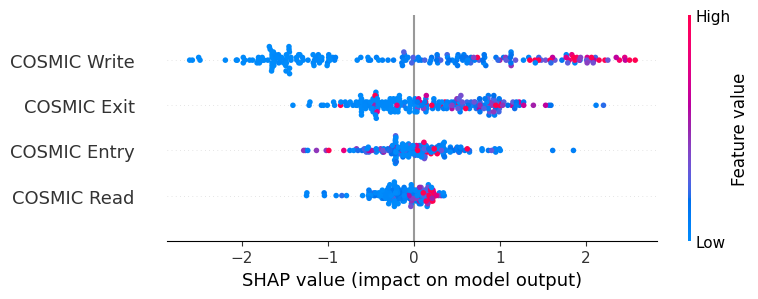


--- Technical Approach ---
R2 (mean ± std): 0.6019 ± 0.1737
MAE (mean ± std): 0.8921 ± 0.1931
MSE (mean ± std): 1.5781 ± 0.6622


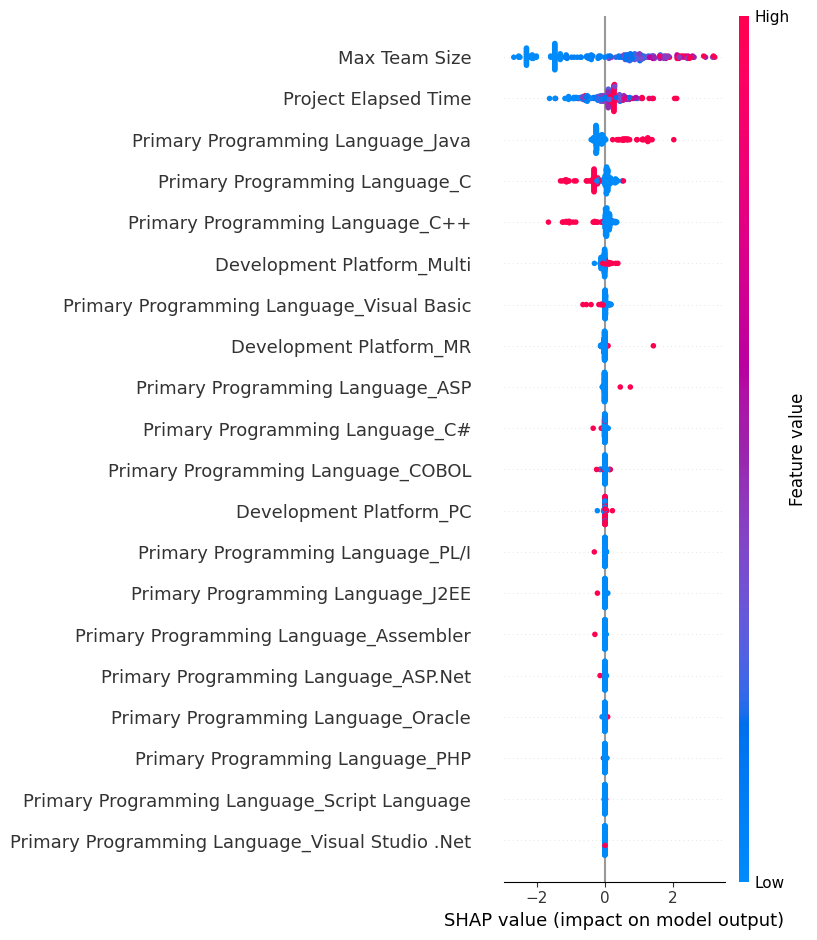

In [5]:
import shap

# Define model
dt = DecisionTreeRegressor(random_state=42)

def evaluate_model(X, y, model=None, label=""):
    if model is None:
        model = DecisionTreeRegressor(random_state=42)
    
    scoring = {
        'r2': 'r2',
        'mae': make_scorer(mean_absolute_error),
        'mse': make_scorer(mean_squared_error),
    }

    # Run cross-validation and collect results
    results = cross_validate(model, X, y, cv=10, scoring=scoring, return_train_score=False)

    print(f"\n--- {label} ---")
    
    # Print the cross-validation scores
    for metric in scoring:
        scores = results[f'test_{metric}']
        print(f"{metric.upper()} (mean ± std): {scores.mean():.4f} ± {scores.std():.4f}")
    
    # Fit the model on the full training data to compute SHAP values
    model.fit(X, y)
    
    # Use SHAP to explain the model's predictions
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)

    # Plot feature importance using SHAP summary plot
    shap.summary_plot(shap_values, X)

# Functional features only
evaluate_model(X_func_train, y_train, label="Functional Approach")

# Technical features (with dummy-coded categoricals)
evaluate_model(X_tech_train, y_train, label="Technical Approach")



--- Functional Approach (MLP) ---
R2 (mean ± std): 0.5004 ± 0.1742
MAE (mean ± std): 1.1110 ± 0.1760
MSE (mean ± std): 1.9717 ± 0.6424


Using 202 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.



--- SHAP Feature Importance for Functional Approach (MLP) ---


100%|██████████| 202/202 [00:02<00:00, 79.41it/s]


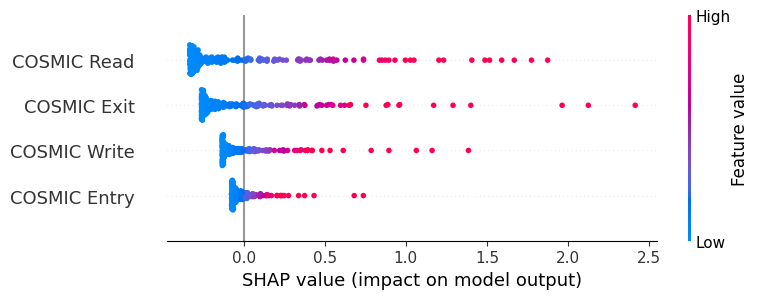


--- Technical Approach (MLP) ---
R2 (mean ± std): 0.6779 ± 0.1143
MAE (mean ± std): 0.8411 ± 0.1282
MSE (mean ± std): 1.2604 ± 0.3946


Using 202 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.



--- SHAP Feature Importance for Technical Approach (MLP) ---


100%|██████████| 202/202 [05:53<00:00,  1.75s/it]


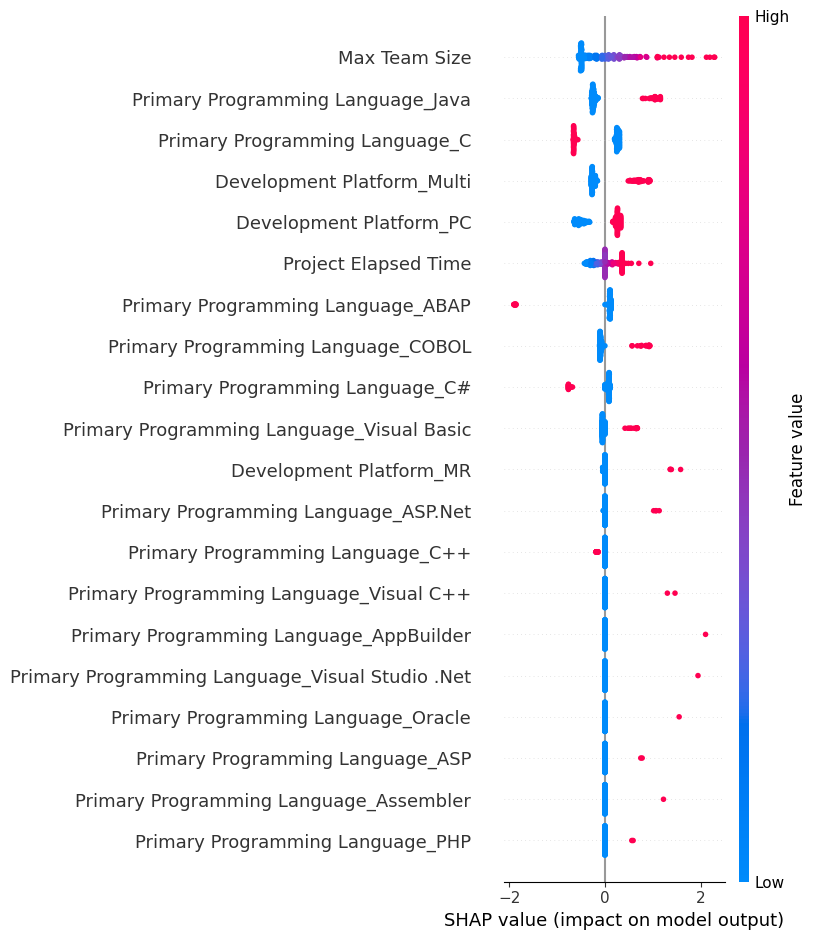

(MLPRegressor(activation='tanh', hidden_layer_sizes=(50, 50), max_iter=1000,
              random_state=42),
       Project Elapsed Time  Max Team Size  Development Platform_MR  \
 1131              0.225496       0.176471                    False   
 3136              0.203261       0.017647                    False   
 1948              0.175468       0.205882                    False   
 1466              0.444136       0.705882                    False   
 4979              0.444136       0.000000                    False   
 ...                    ...            ...                      ...   
 2308              0.444136       0.000000                    False   
 429               0.203261       0.170588                    False   
 2078              0.177321       0.441176                    False   
 4214              0.444136       0.023529                    False   
 2283              0.203261       0.152941                    False   
 
       Development Platform_Multi  De

In [6]:
import shap
from sklearn.neural_network import MLPRegressor
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error

# Suppress only the convergence warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Define the MLPRegressor model (you can adjust the hyperparameters as needed)
mlp = MLPRegressor(hidden_layer_sizes=(50, 50), activation='tanh', solver='adam', max_iter=1000, random_state=42, early_stopping=False)

def evaluate_model(X, y, model=None, label=""):
    if model is None:
        model = MLPRegressor(hidden_layer_sizes=(50, 50), activation='tanh', solver='adam', max_iter=1000, random_state=42, early_stopping=False)
    
    scoring = {
        'r2': 'r2',
        'mae': make_scorer(mean_absolute_error),
        'mse': make_scorer(mean_squared_error),
    }

    # Run cross-validation and collect results
    results = cross_validate(model, X, y, cv=10, scoring=scoring, return_train_score=False)

    print(f"\n--- {label} ---")
    
    # Print the cross-validation scores
    for metric in scoring:
        scores = results[f'test_{metric}']
        print(f"{metric.upper()} (mean ± std): {scores.mean():.4f} ± {scores.std():.4f}")
    
    # Fit the model on the full training data to compute SHAP values
    model.fit(X, y)  # Fit the model on the full dataset after cross-validation

    # SHAP analysis
    print(f"\n--- SHAP Feature Importance for {label} ---")
    explainer = shap.KernelExplainer(model.predict, X)  # KernelExplainer for MLPRegressor
    shap_values = explainer.shap_values(X)

    # Plot feature importance using SHAP summary plot
    shap.summary_plot(shap_values, X)

    # Return the trained model and feature set
    return model, X

# Directly call the evaluate_model function without creating another variable
evaluate_model(X_func_train, y_train, model=mlp, label="Functional Approach (MLP)")
evaluate_model(X_tech_train, y_train, model=mlp, label="Technical Approach (MLP)")



--- Functional Approach (XGBoost) ---
R2 (mean ± std): 0.5825 ± 0.1204
MAE (mean ± std): 1.0100 ± 0.1415
MSE (mean ± std): 1.6513 ± 0.5051

--- SHAP Feature Importance for Functional Approach (XGBoost) ---


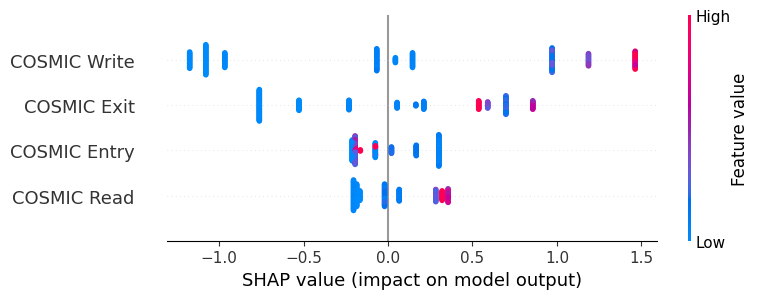


--- Technical Approach (XGBoost) ---
R2 (mean ± std): 0.7141 ± 0.0919
MAE (mean ± std): 0.8399 ± 0.1946
MSE (mean ± std): 1.1631 ± 0.4338

--- SHAP Feature Importance for Technical Approach (XGBoost) ---


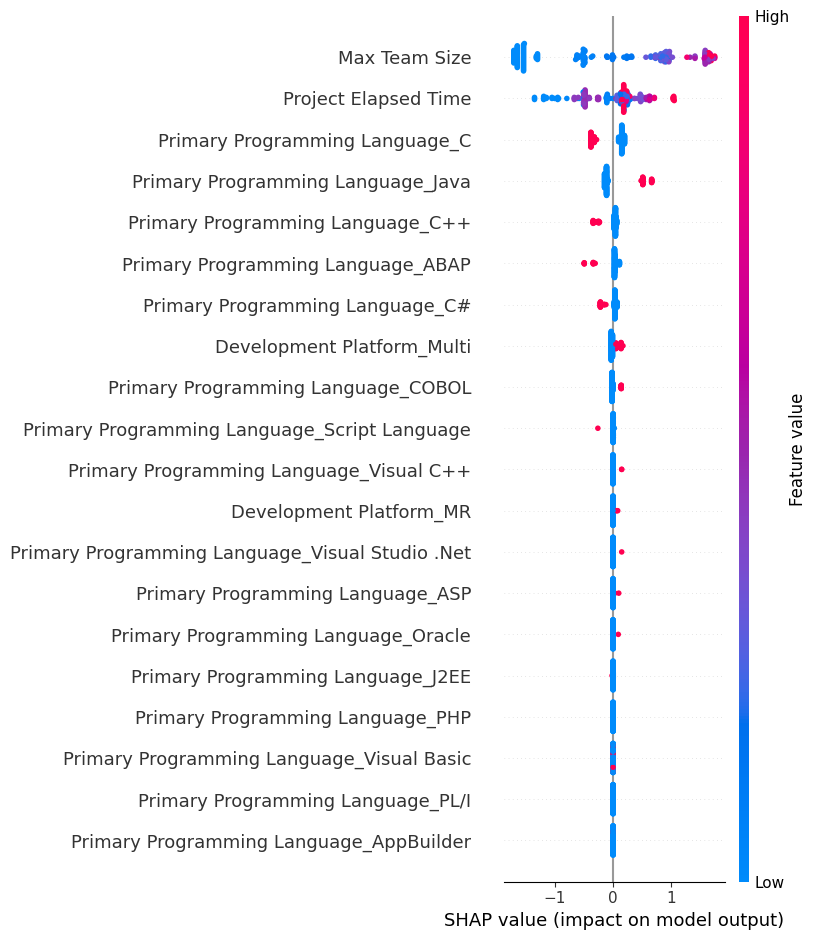


--- Technical Approach w/o Project Elapsed Time (XGBoost) ---
R2 (mean ± std): 0.6538 ± 0.0988
MAE (mean ± std): 0.9204 ± 0.1840
MSE (mean ± std): 1.3828 ± 0.4425

--- SHAP Feature Importance for Technical Approach w/o Project Elapsed Time (XGBoost) ---


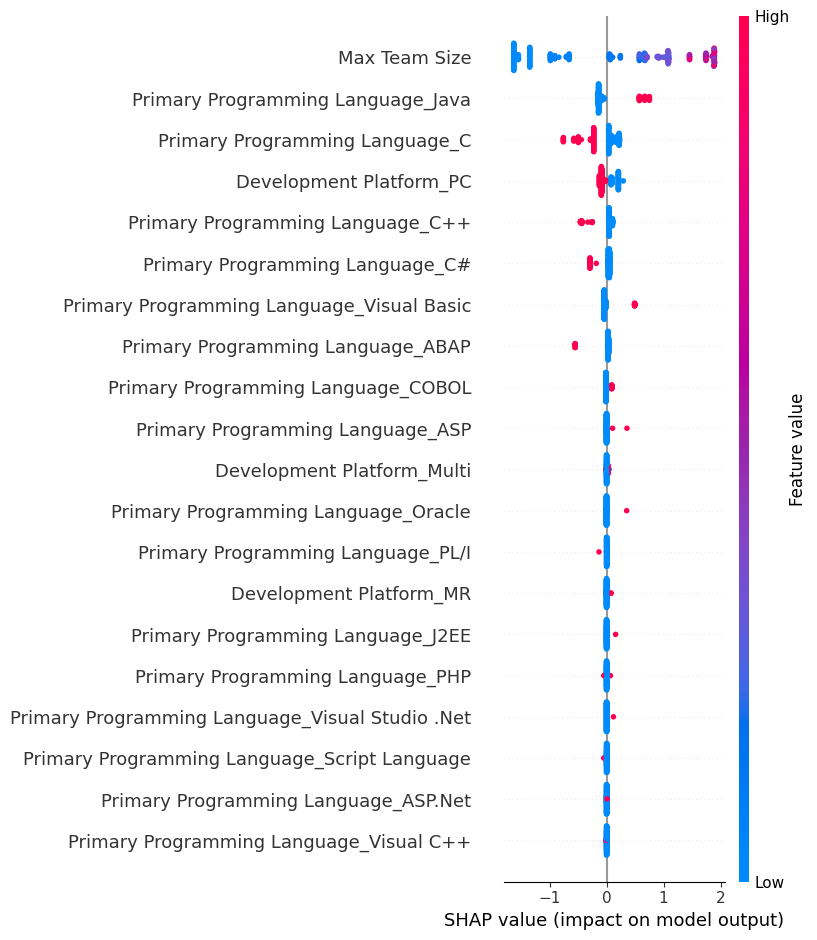

(XGBRegressor(alpha=10, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.3, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.3, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, ...),
       Max Team Size  Development Platform_MR  Development Platform_Multi  \
 1131       0.176471                    False                       False   
 3136       0.017647                    False                        True   
 1948       0.205882      

In [7]:
import shap
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer

# Define the XGBoost model
xg_reg = xgb.XGBRegressor(
    objective='reg:squarederror', 
    colsample_bytree=0.3, 
    learning_rate=0.6,
    max_depth=10, 
    alpha=10, 
    n_estimators=100, 
    verbosity=0, 
    random_state=42
)

def evaluate_model(X, y, model=None, label=""):
    if model is None:
        model = xgb.XGBRegressor(
            objective='reg:squarederror', 
            colsample_bytree=0.3, 
            learning_rate=0.6,
            max_depth=10, 
            alpha=10, 
            n_estimators=100, 
            verbosity=0, 
            random_state=42
        )
    
    scoring = {
        'r2': 'r2',
        'mae': make_scorer(mean_absolute_error),
        'mse': make_scorer(mean_squared_error),
    }

    # Run cross-validation and collect results
    results = cross_validate(model, X, y, cv=10, scoring=scoring, return_train_score=False)

    print(f"\n--- {label} ---")
    
    # Print the cross-validation scores
    for metric in scoring:
        scores = results[f'test_{metric}']
        print(f"{metric.upper()} (mean ± std): {scores.mean():.4f} ± {scores.std():.4f}")
    
    # Fit the model on the full training data to compute SHAP values
    model.fit(X, y)  # Fit the model on the full dataset after cross-validation

    # SHAP analysis
    print(f"\n--- SHAP Feature Importance for {label} ---")
    explainer = shap.TreeExplainer(model)  # TreeExplainer for XGBoost model
    shap_values = explainer.shap_values(X)

    # Plot feature importance using SHAP summary plot
    shap.summary_plot(shap_values, X)

    # Return the trained model and feature set
    return model, X

# Evaluate functional approach with XGBoost
evaluate_model(X_func_train, y_train, model=xg_reg, label="Functional Approach (XGBoost)")

# Evaluate technical approach with XGBoost
evaluate_model(X_tech_train, y_train, model=xg_reg, label="Technical Approach (XGBoost)")

# Evaluate technical approach without Project Elapsed Time using XGBoost
evaluate_model(
    X_tech_train.drop(columns=['Project Elapsed Time']), 
    y_train, 
    model=xgb.XGBRegressor(
        objective='reg:squarederror',
        colsample_bytree=0.3,
        learning_rate=0.3,
        max_depth=10,
        alpha=10,
        n_estimators=100,
        verbosity=0,
        random_state=42
    ),
    label="Technical Approach w/o Project Elapsed Time (XGBoost)"
)


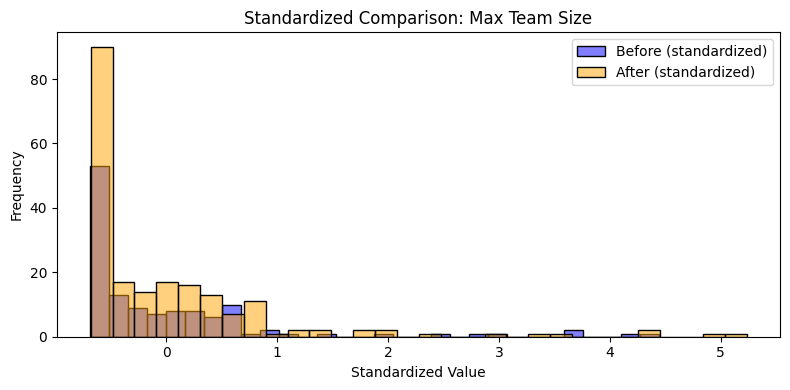

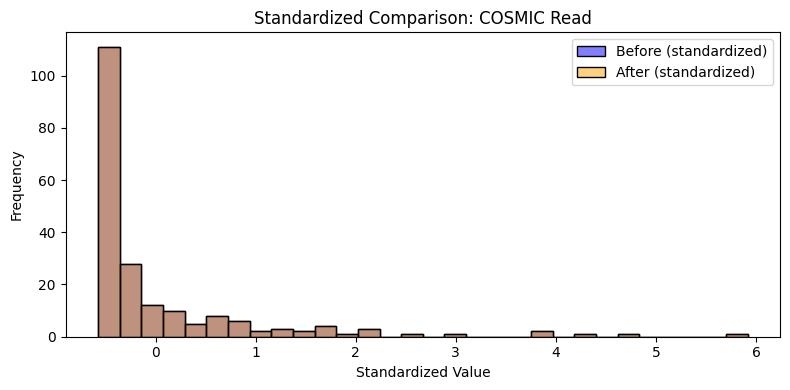

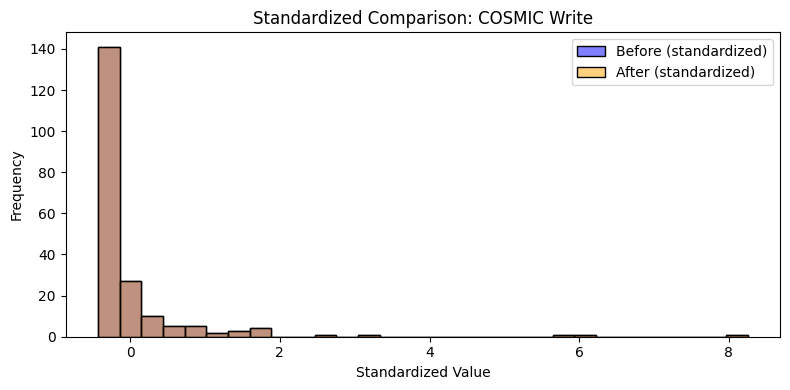

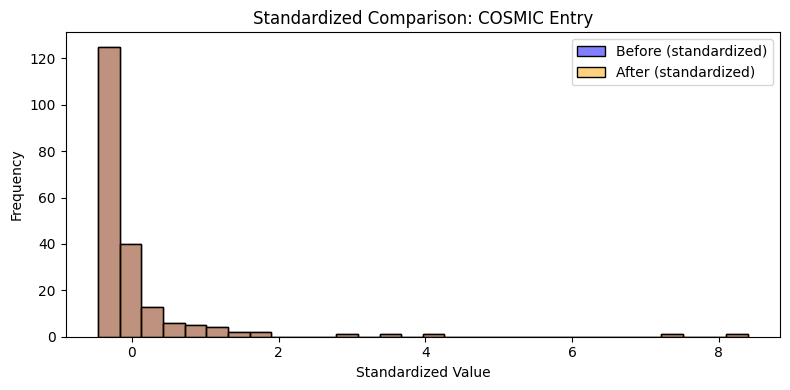

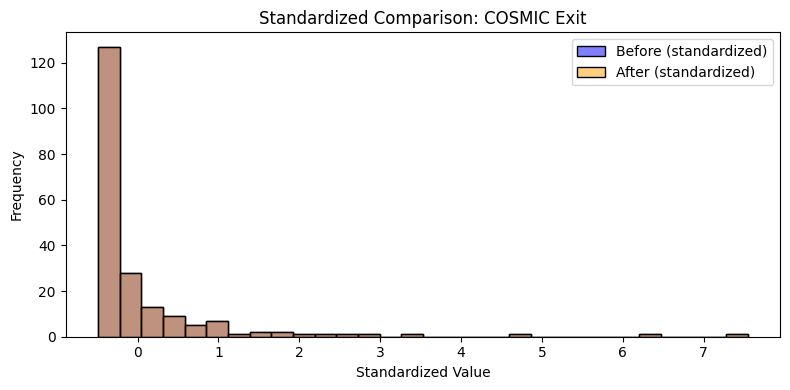

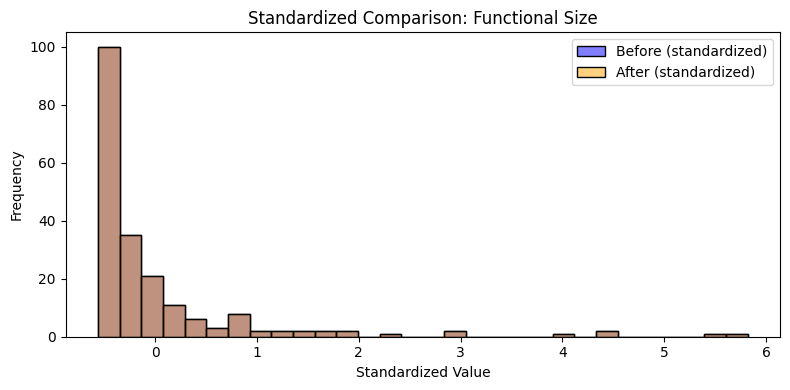

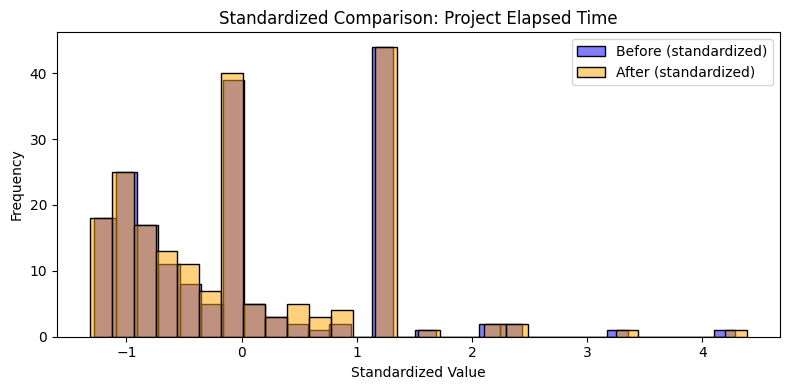

In [8]:
def standardize_for_plotting(data):
    return (data - data.mean()) / data.std()

def plot_standardized_distributions(X_before, X_after, features=None, bins=30):
    import matplotlib.pyplot as plt
    import seaborn as sns

    if features is None:
        features = X_before.columns.intersection(X_after.columns)

    for col in features:
        plt.figure(figsize=(8, 4))
        sns.histplot(standardize_for_plotting(X_before[col]), label='Before (standardized)', color='blue', bins=bins, alpha=0.5)
        sns.histplot(standardize_for_plotting(X_after[col]), label='After (standardized)', color='orange', bins=bins, alpha=0.5)
        plt.title(f'Standardized Comparison: {col}')
        plt.xlabel('Standardized Value')
        plt.ylabel('Frequency')
        plt.legend()
        plt.tight_layout()
        plt.show()

plot_standardized_distributions(X_train, X_train_final, features=num_cols, bins=30)

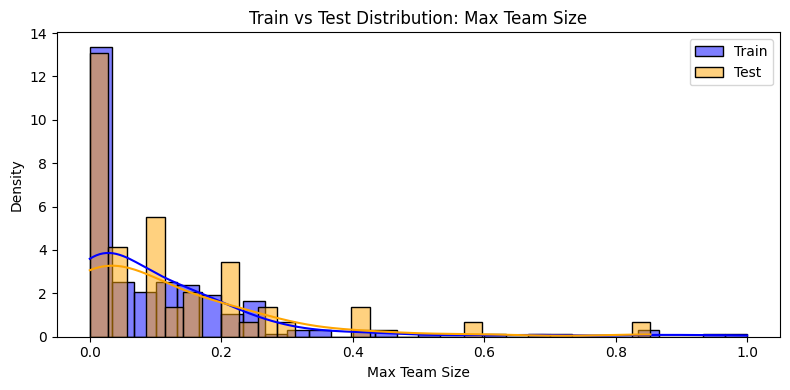

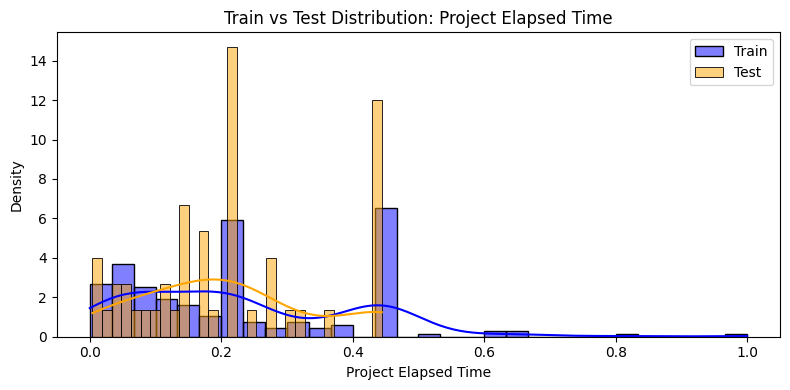

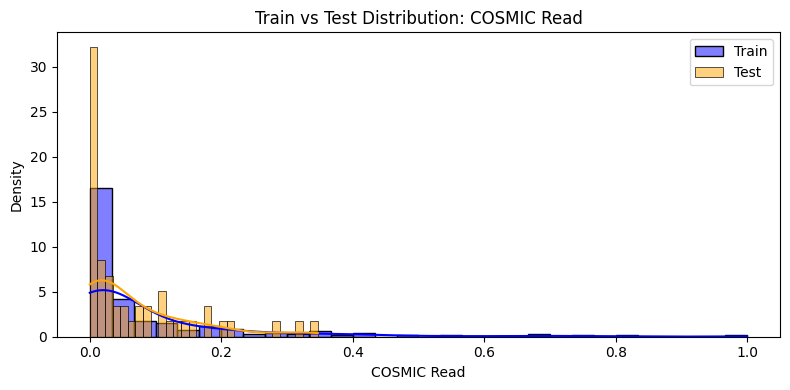

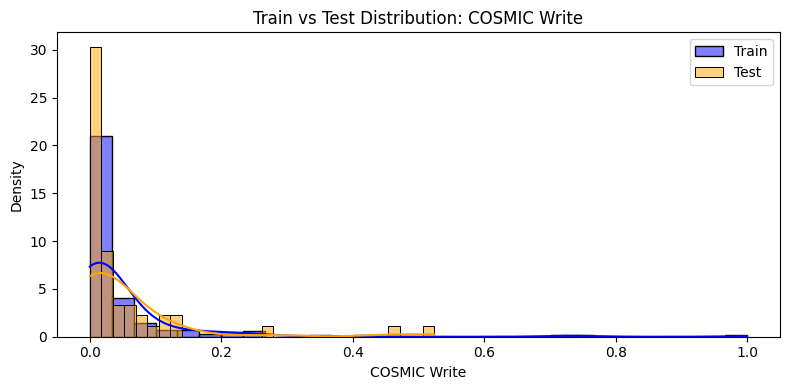

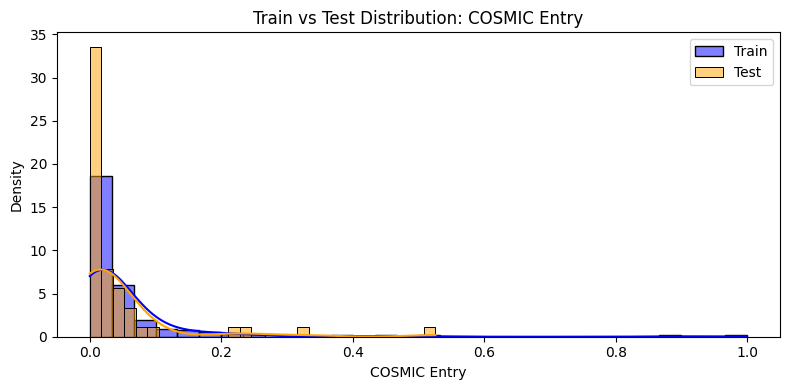

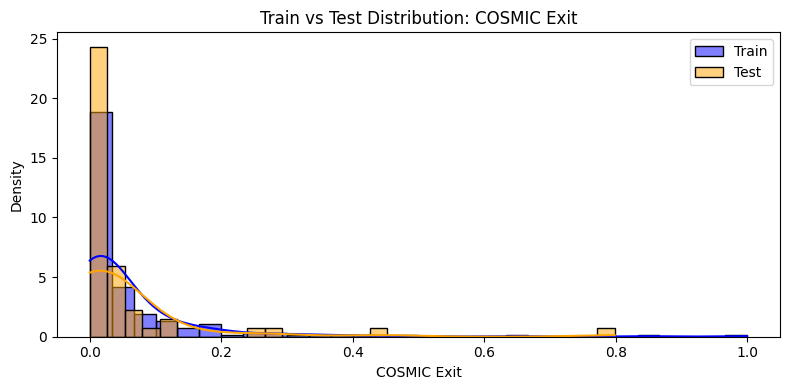

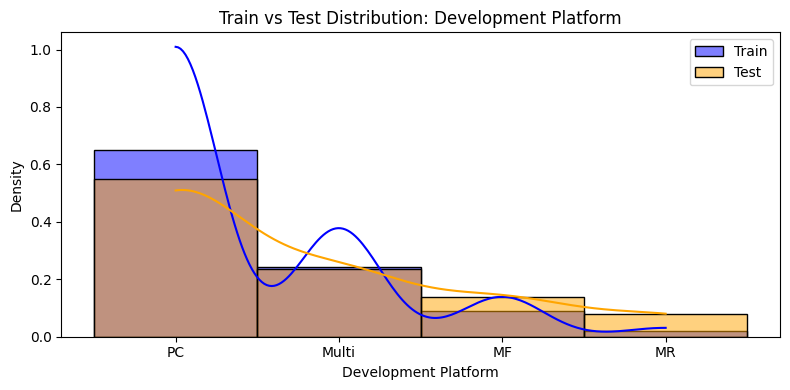

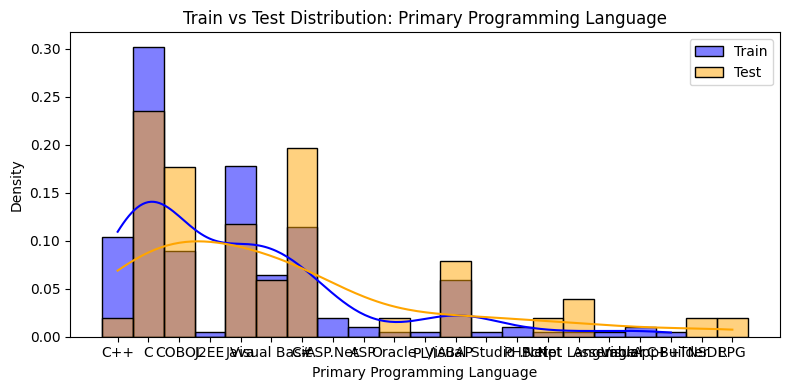

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_train_test_feature_distributions(X_train, X_test, features=None, bins=30):
    if features is None:
        features = X_train.columns
    
    for feature in features:
        plt.figure(figsize=(8, 4))
        sns.histplot(X_train[feature], bins=bins, color='blue', label='Train', stat='density', kde=True, alpha=0.5)
        sns.histplot(X_test[feature], bins=bins, color='orange', label='Test', stat='density', kde=True, alpha=0.5)
        plt.title(f"Train vs Test Distribution: {feature}")
        plt.xlabel(feature)
        plt.ylabel("Density")
        plt.legend()
        plt.tight_layout()
        plt.show()


plot_train_test_feature_distributions(X_train_final, X_test_final, features=["Max Team Size", "Project Elapsed Time"])
plot_train_test_feature_distributions(X_train_final, X_test_final, features=["COSMIC Read", "COSMIC Write", "COSMIC Entry", "COSMIC Exit"])
plot_train_test_feature_distributions(X_train_final, X_test_final, features=["Development Platform", "Primary Programming Language"])